# Метрики качества

Сегодня мы затронем вопрос, который на первый взгляд может показаться тривиальным - как измерить качество уже построенного классификатора?

Первой идеей, которая придет в голову каждому, наверняка станет метрика, которую мы с вами регулярно использовали в течение нашего курса. Начнем с неё.

# 1. Accuracy
### Доля верных ответов классификатора

Самая очевидная и интуитивно понятная метрика. Для того чтобы посчитать *accuracy* мы возьмём исходный датасет, состоящий из $N$ объектов, и посмотрим сколько из них были классифицированы верно. Пусть это число $M$. Тогда: $$Accuracy = \frac{M}{N}$$

Казалось бы, что еще нужно?
Это ведь и есть та самая метрика, которая максимально объективно отображает эффективность нашего алгоритма!

Оказывается, у *accuracy* есть свои проблемы, которые зачастую делают эту метрику совсем не самой репрезентативной, а иногда - даже сбивающей с толку!

Рассмотрим пример.

### Пример
______________________
______________________

Пусть наша с вами задача - провести классификацию пациентов с подозрением на серьезную болезнь на тех, кого следует позвать на дополнительное обследование к врачу, и тех, кого можно не приглашать.

Каждый пациент описывается некоторым вектором $\vec{x}$, пусть первая координата этого вектора задает наличие жалоб у пациентов на самочувствие.

Зададим синтетический датасет следующим образом:

* Пусть у нас есть 950 здоровых людей и 50 больных.
* Пусть 40 из 50 больных чувствую себя плохо, то есть первая координата вектора их описания будет равна единице.
* Пусть среди 950 здоровых людей есть ипохондрики, то есть те, кто, будучи здоровыми, считают себя больными. Пусть их будет около 100 человек.

In [ ]:
import warnings
import numpy as np
from random import shuffle

warnings.filterwarnings('ignore')
# Определяем размерность данных
x_shape = 3

# Данные о здоровых людях
health_X = np.random.randn(950, x_shape)
health_f = [0] * 850 + [1] * 100
shuffle(health_f)
health_X[:, 0] = health_f

# Данные о больных людях
ill_x = np.random.randn(50, x_shape)
ill_f = [0] * 10 + [1] * 40
shuffle(ill_f)
ill_x[:, 0] = ill_f

# Объединяем датасеты
X = np.concatenate((health_X, ill_x))

# Создаем метки для объединенных данных
Y = np.concatenate((np.zeros(950), np.ones(50)))

print(f"Размер X: {X.shape}")
print(f"Количество здоровых данных: {np.sum(Y == 0)}")
print(f"Количество больных данных: {np.sum(Y == 1)}")

Размер X: (1000, 3)
Количество здоровых данных: 950
Количество больных данных: 50


Датасет готов. Давайте теперь определим 2 классификатора.

Пусть один из них будет поумнее, другой - поглупее.

* Классификатор номер 1 будет давать предсказание, основываясь на самочувствии пациента
* Классификатор номер 2 будет всех определять в группу здоровых

In [ ]:
classifier_1 = lambda x: (x[:,0] == 1).astype(int) # Сравнение с признаком самочувствия
classifier_2 = lambda x: np.zeros_like(x[:,0]) # Константное предсказание

In [ ]:
y_1 = classifier_1(X) # Предсказание первого классификатора
y_2 = classifier_2(X) # Предсказание второго классификатора

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_1 = accuracy_score(y_1, Y)
accuracy_2 = accuracy_score(y_2, Y)
print(f"Точность классификатора №1 (умного): {accuracy_1}")
print(f"Точность классификатора №2 (константного): {accuracy_2}")

Точность классификатора №1 (умного): 0.89
Точность классификатора №2 (константного): 0.95


Этот результат не такой уж неожиданный. Давайте посмотрим на распределения наших групп.

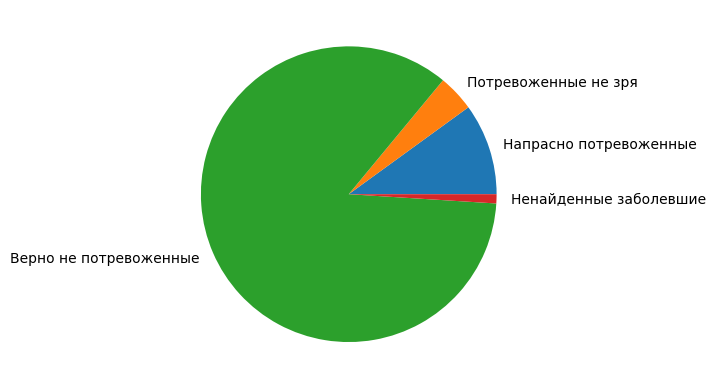

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


labels = [
    "Напрасно потревоженные",
    "Потревоженные не зря",
    "Верно не потревоженные",
    "Ненайденные заболевшие",
]

values = [
    (y_1 * (1 - Y)).sum(),
    (y_1 * Y).sum(),
    ((1 - y_1) * (1 - Y)).sum(),
    ((1 - y_1) * Y).sum(),
]
pie = plt.pie(values, labels=labels)

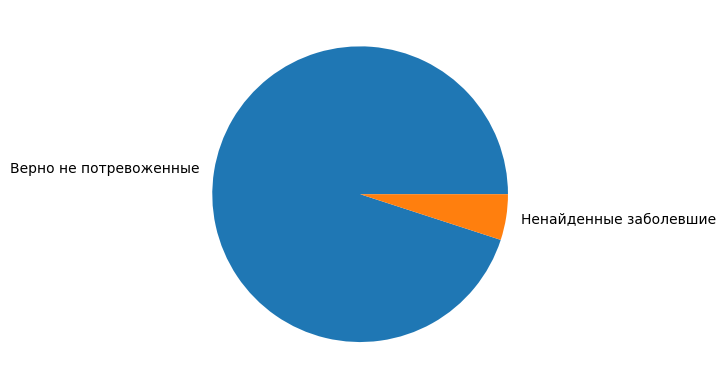

In [ ]:
labels = ["Верно не потревоженные", "Ненайденные заболевшие"]

values = [((1 - y_2) * (1 - Y)).sum(), ((1 - y_2) * Y).sum()]
pie = plt.pie(values, labels=labels)

То есть доля верных ответов действительно больше для классификатора 2, поскольку он не потревожил зря ни одного здорового человека. Но и ни одного больного он не нашел.

Очевидно, что второй классификатор будет абсолютно бесполезен, если не сказать вреден, для нас. Значит, *accuracy* не всегда поможет нам отличить хороший классификатор от плохого.

Одна из проблем, с которой может столкнуться метрика *accuracy* - это **дисбаланс классов**, то есть ситуация, при которой классы не одинаково распределены в нашем датасете, одних из классов существенно больше, а других существенно меньше.

# Precision и Recall (Точность и Полнота)

Прежде чем перейти к описанию этих метрики, введем понятие ***матрицы ошибок***.

## Матрица ошибок
________________________________________________
________________________________________________
Пусть у нас есть задача бинарной классификации, датасет $\{{(x_i,y_i)}\}_{i=1}^N$

Пусть есть классификатор $a(x)$.
Тогда каждый раз, когда мы применяем алгоритм $a$ к объекту $x_i$ у нас есть 4 варианта:

* $a(x_i) = y_i = 0$ — такая ситуация называется **True Negative (TN)**
* $a(x_i) = y_i = 1$ — такая ситуация называется **True Positive (TP)**
* $a(x_i) = 1 \neq y_i = 0$ — такая ситуация называется **False Positive (FP)**
* $a(x_i) = 0 \neq y_i = 1$ — такая ситуация называется **False Negative (FN)**


Эту структуру обычно записывают в матрицу: считают, сколько классификаций относятся к каждому из этих классов.

В нашем случае соответствие будет следующим:

- TP = Потревоженные не зря
- FP = Зря потревоженные
- TN = Верно не потревоженные
- FN = Ненайденные заболевшие



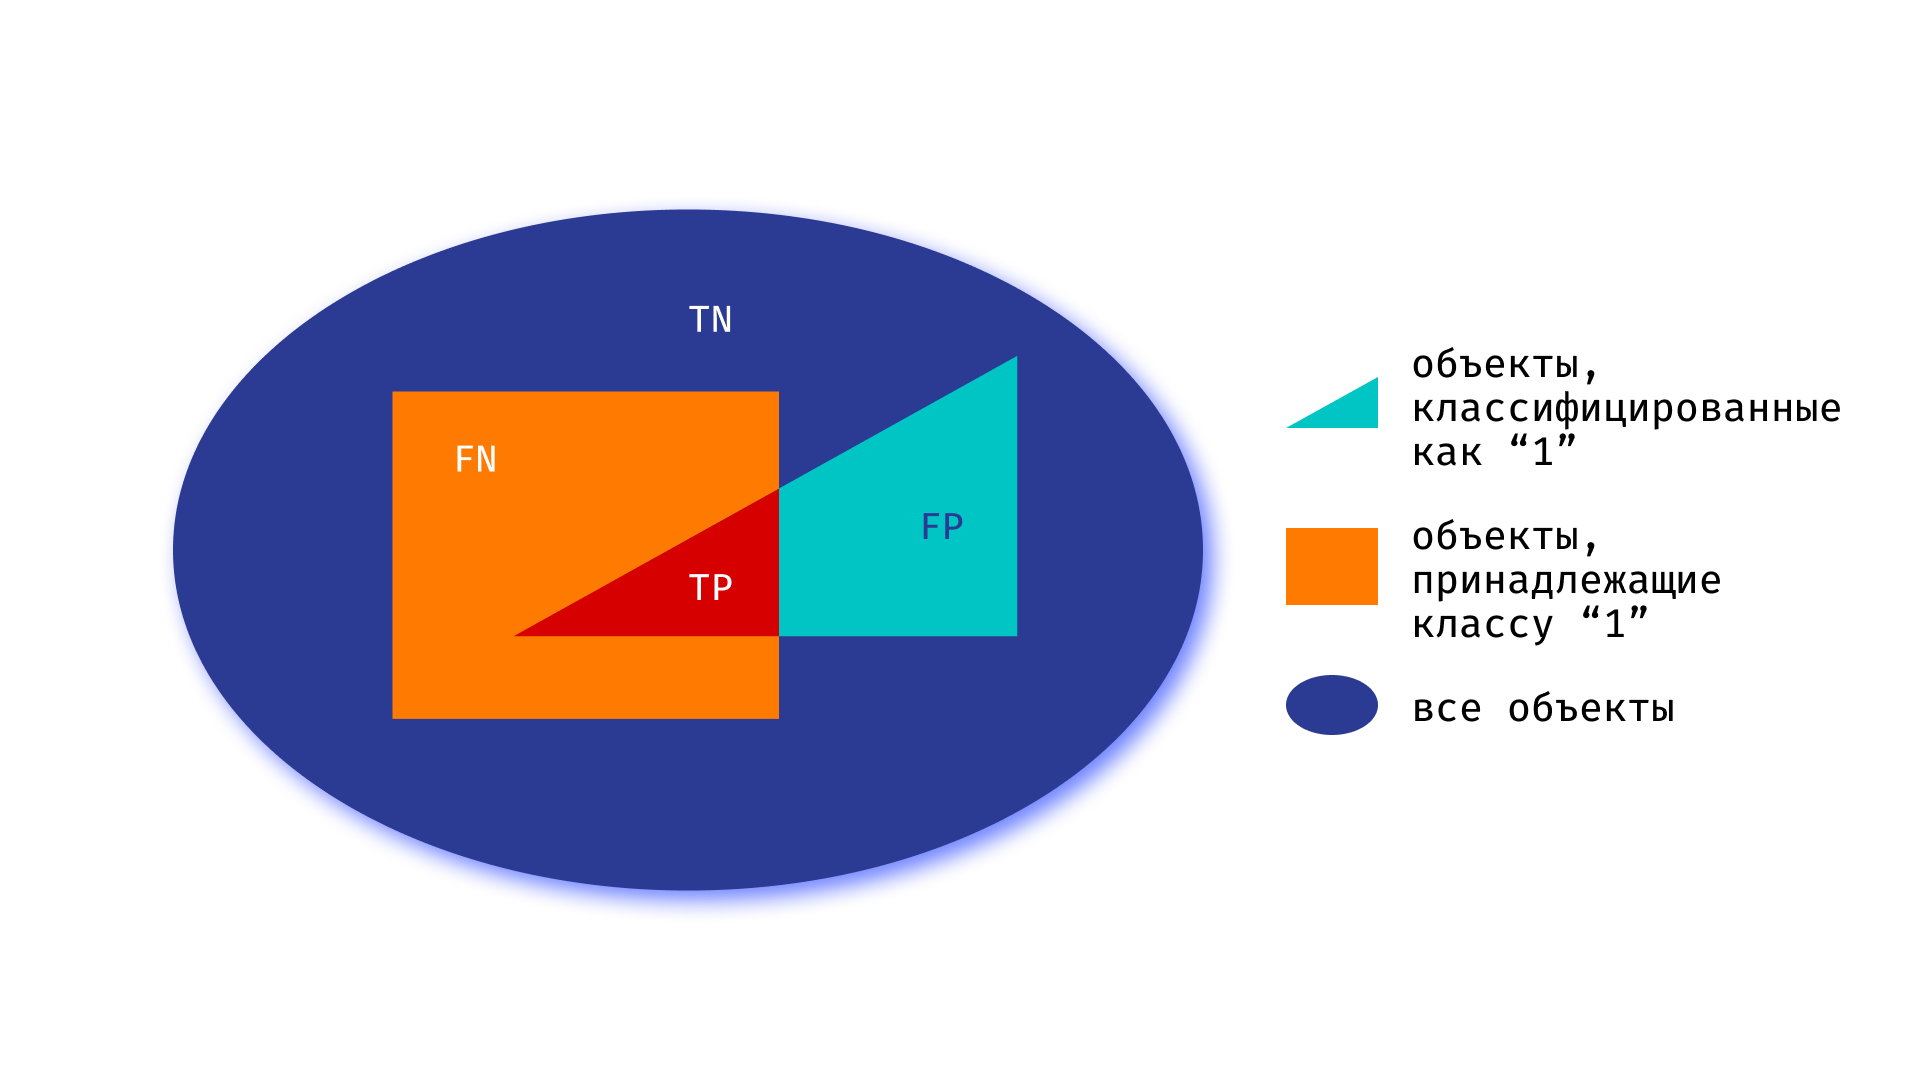

In [ ]:
import pandas as pd

TP = (y_1 * Y).sum()
FP = (y_1 * (1 - Y)).sum()
TN = ((1 - y_1) * (1 - Y)).sum()
FN = ((1 - y_1) * Y).sum()

TP_2 = (y_2 * Y).sum()
FP_2 = (y_2 * (1 - Y)).sum()
TN_2 = ((1 - y_2) * (1 - Y)).sum()
FN_2 = ((1 - y_2) * Y).sum()

df = pd.DataFrame({"a(x) = 1": [TP, FP], "a(x) = 0": [FN, TN]}, index=["y=1", "y=0"])
df

,a(x) = 1,a(x) = 0
y=1,40.0,10.0
y=0,100.0,850.0


In [ ]:
df_2 = pd.DataFrame({"a(x) = 1": [TP_2, FP_2], "a(x) = 0": [FN_2, TN_2]}, index=["y=1", "y=0"])
df_2

,a(x) = 1,a(x) = 0
y=1,0.0,50.0
y=0,0.0,950.0


________________________________________________
________________________________________________

Теперь мы рассмотрим 2 метрики, отражающие разные стороны качества классификации.





## Precision
Первая из них называется **Precision (Точность)**

Точность классификации определяется следующим образом:
$$Prec(X, a(x)) = \frac{TP}{TP + FP}$$

Иначе говоря, precision показывает, какую часть из приглашенных на обследование пациентов мы потревожили не зря. Чем больше precision, тем меньше потревоженных пациентов будет. Точность показывает степень уверенности в том, что объект, который классификатор определил к классу 1 **действительно принадлежит этой группе**.


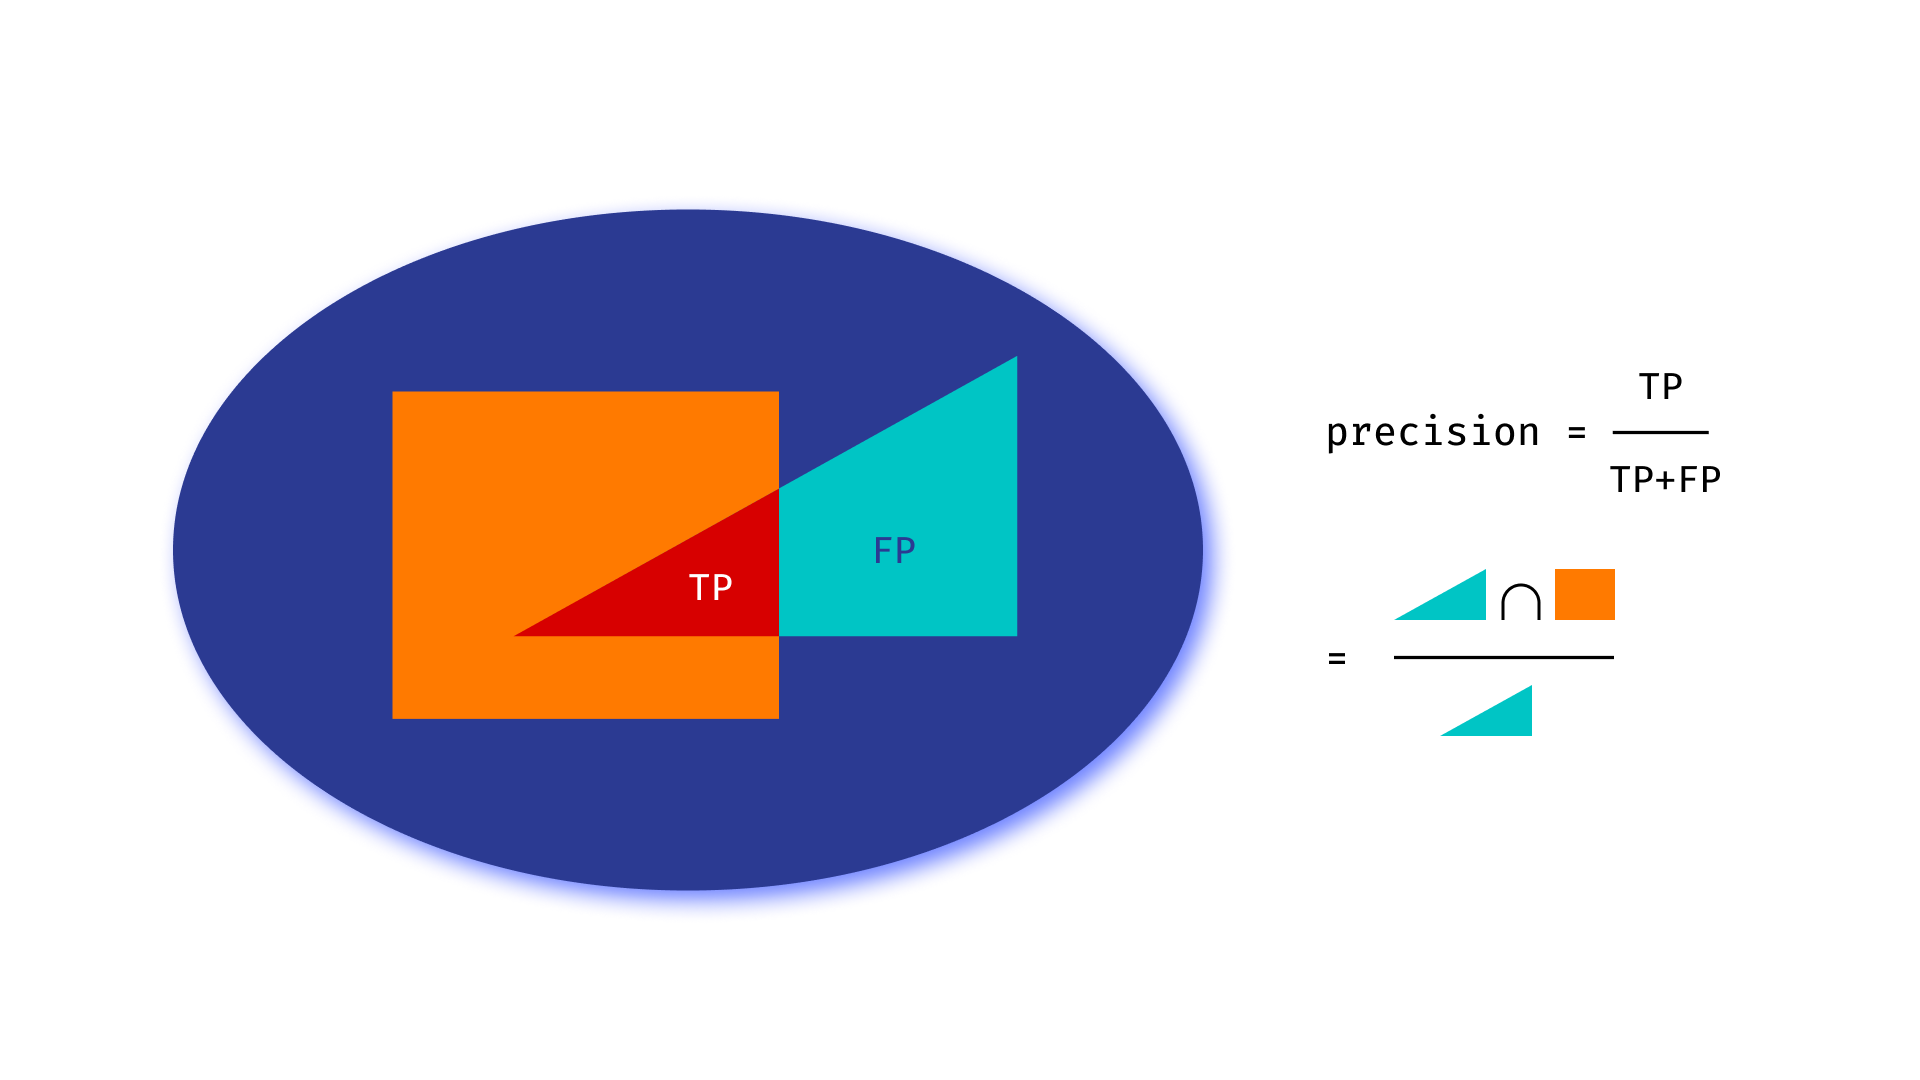

## Recall

Вторая метрика называется **Recall (Полнота)**
$$Rec(X, a(x)) = \frac{TP}{TP + FN}$$

Полнота же показывает нам, скольких пациентов из группы тех, кому нужна наша помощь, мы пригласили в действительности. Recall демонстрирует уверенность в том, что объект класса 1 не будет упущен нами из виду.


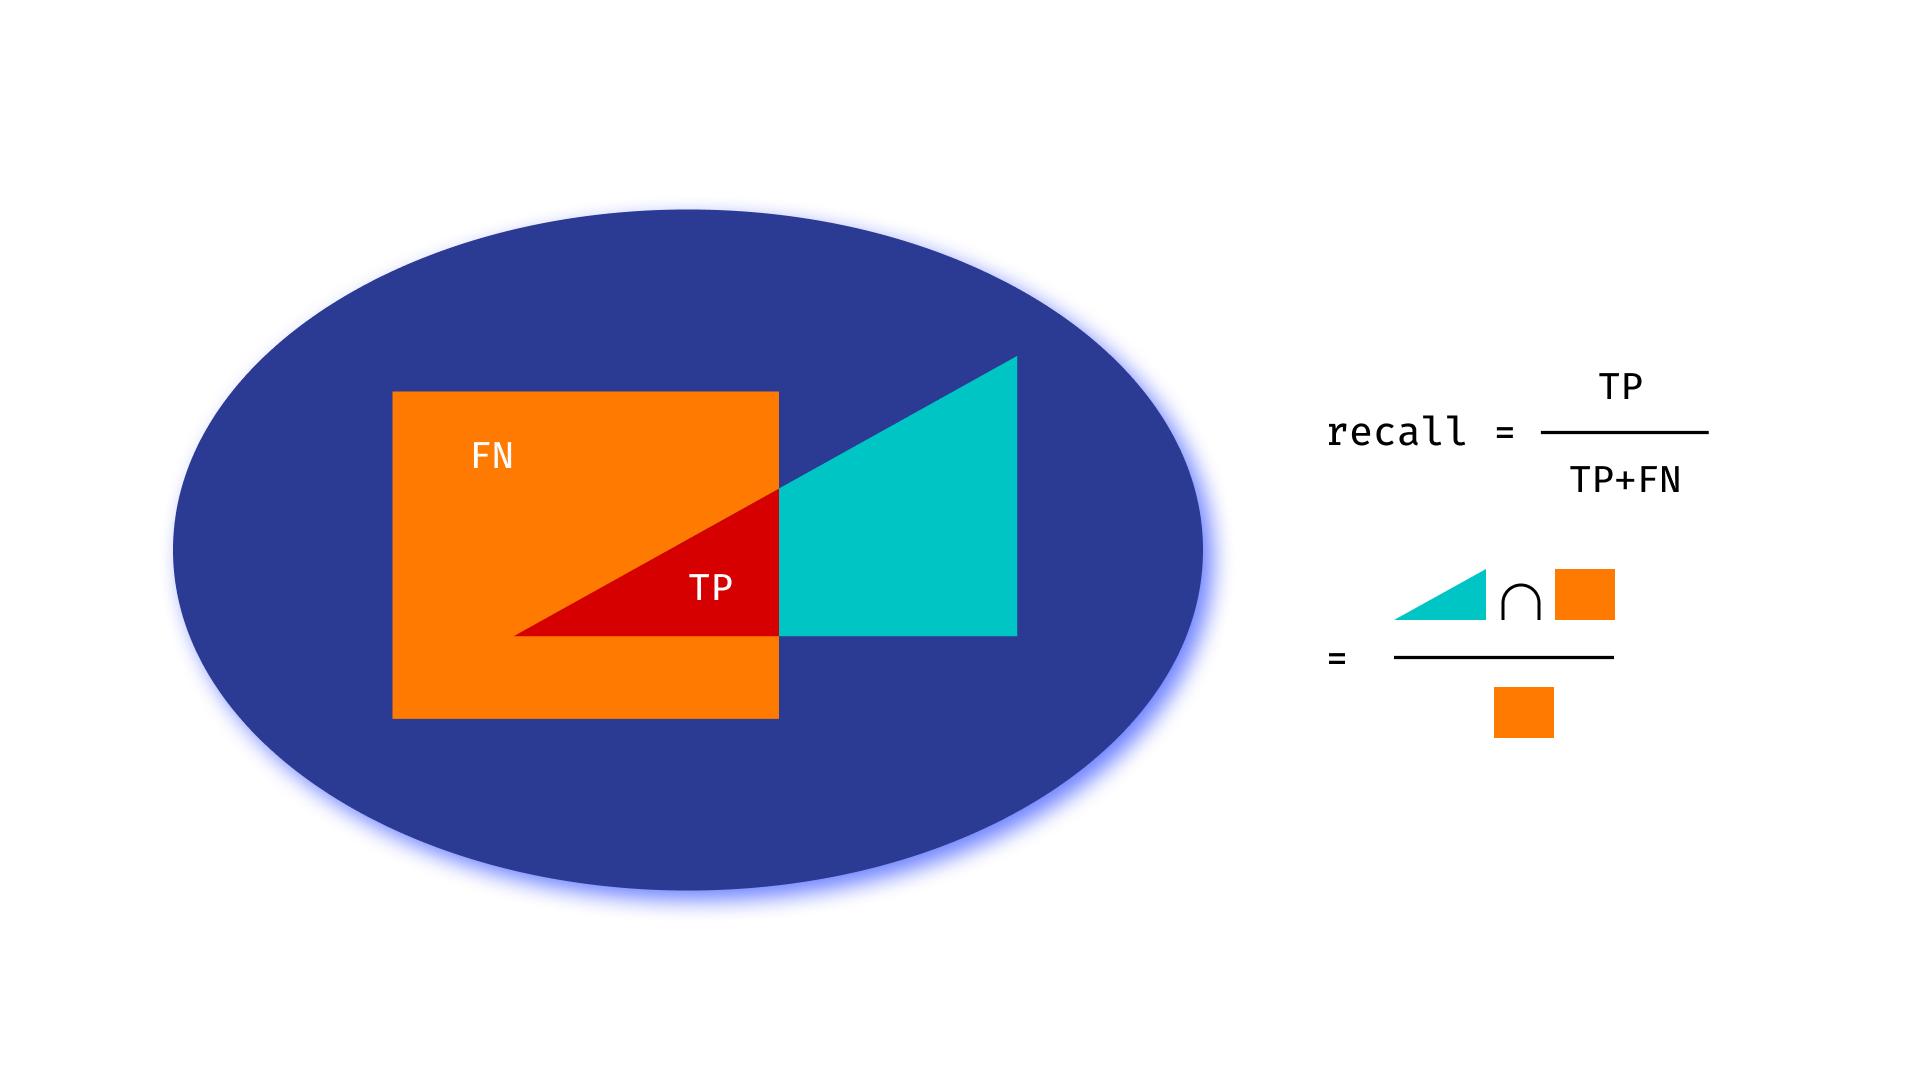

Посчитаем Precision и Recall в нашем случае

In [ ]:
precision_1 = TP / (TP + FP + 1e-5)
precision_2 = TP_2 / (TP_2 + FP_2 + 1e-5)

recall_1 = TP / (TP + FN)
recall_2 = TP_2 / (TP_2 + FN_2 + 1e-5)

print(f"Точность умного алгоритма: {precision_1}")
print(f"Точность константного алгоритма: {precision_2}")
print(f"Полнота умного алгоритма: {recall_1}")
print(f"Полнота константного алгоритма: {recall_2}")

Точность умного алгоритма: 0.2857142653061239
Точность константного алгоритма: 0.0
Полнота умного алгоритма: 0.8
Полнота константного алгоритма: 0.0


А что если у нас будет константный алгоритм, но называющим больным каждого пациента?

In [ ]:
classifier_3 = lambda x: np.ones_like(x[:,0]) # Константное предсказание
y_3 = classifier_3(X)

In [ ]:
TP_3 = (y_3 * Y).sum()
FP_3 = (y_3 * (1 - Y)).sum()
TN_3 = ((1 - y_3) * (1 - Y)).sum()
FN_3 = ((1 - y_3) * Y).sum()

precision_3 = TP_3 / (TP_3 + FP_3 + 1e-5)
recall_3 = TP_3 / (TP_3 + FN_3 + 1e-5)

In [ ]:
print(f'Точность алгоритма-паникёра: {precision_3}')
print(f'Полнота алгоритма-паникёра: {recall_3}')

Точность алгоритма-паникёра: 0.0499999995
Полнота алгоритма-паникёра: 0.99999980000004


**Нам нужен компромисс между этими двумя метриками**



## F1-measure

F1-мера пытается объединить эти две метрики в одну, следуя следующим пожеланиям:

1. При одинаковых $recall$ значение $f1$ должно быть выше у того алгоритма, у которого выше $precision$.

2. При одинаковых $precision$ значение $f1$ должно быть выше у того алгоритма, у которого выше $recall$.

3. $f1$ должна быть больше у того алгоритма, для которого поддерживается баланс между $precision$ и $recall$ при условии максимизации обеих.

Таким требованиям отлично удовлетворяет среднее гармоническое $precision$ и $recall$ алгоритма: $$f1 = 2\frac{precision*recall}{(precision + recall)}$$

In [ ]:
f1 = lambda prec, recall: 2 * prec * recall / (prec + recall + 1e-5)

In [ ]:
print(f'f1 умного алгоритма: {f1(precision_1, recall_1)}')
print(f'f1 константного алгоритма: {f1(precision_2, recall_2)}')
print(f'f1 алгоритма-паникёра: {f1(precision_3, recall_3)}')

f1 умного алгоритма: 0.4210487313377906
f1 константного алгоритма: 0.0
f1 алгоритма-паникёра: 0.09523718640304021


Конечно, нам не обязательно каждый раз писать эти метрики руками. Мы можем взять их из `sklearn`

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'f1 умного алгоритма: {f1_score(y_1, Y)}')
print(f'f1 константного алгоритма: {f1_score(y_2, Y)}')
print(f'f1 алгоритма-паникёра: {f1_score(y_3, Y)}')

f1 умного алгоритма: 0.42105263157894735
f1 константного алгоритма: 0.0
f1 алгоритма-паникёра: 0.09523809523809523


# Метрики качества мягкой классификации

Мягкая классификация - это способ проведения классификации, при котором алгоритм возвращает нам не решение в явном виде (то есть класс 1 или 0), а вероятность принадлежности объекта классу 1 (как в случае логистической регрессии).

В этом случае мы хотим учесть не только правильность ответов, но и уверенность модели в этих ответах.

Пусть $b(x_i)$ - это оценка принадлежности объекта $x_i$ классу 1. Каким образом мы проводим классификацию этого объекта?

Мы сравниваем эту оценку $b(x_i)$ со значением 0.5, то есть $$a(x_i) = [b(x_i) >0.5]$$

Значение 0.5 выбрано в данном случае из соображений того, что мы вопсринимаем $b(x_i)$ как **вероятность**. Вспомним, как во время разговора о сигмоидальной функции, которая является выходом алгоритма логистической регрессии, мы говорили, что выход сигмоиды мы можем **интерпретировать как вероятность**, но никто не гарантирует нам, что она ей является. Исходя из этого, мы можем предположить, что 0.5 - не обязательно оптимальное значение, с которым мы сравниваем выход нашего алгоритма.

То есть в общем случае, алгоритм принятия решения выглядит так: $$a_t(x_i) = [b(x_i) > t]$$ где $t$ - некоторый определенный заранее порог.

Пусть теперь у нас есть выборка $X$= $\{(x_i,y_i)\}_{i=1}^N$. Упорядочим объекты $x_{(1)} ... x_{(N)}$ в порядке возрастания оценки $b(x)$.

$$b(x_{(1)}) \leq ... \leq b(x_{(N)})$$

И переберем все эти значения в качестве порогов классификации
$$t_1 = b(x_{(1)})$$
$$...$$
$$t_N = b(x_{(N)})$$


Рассмотрим набор классификаторов $a_{t_1}(x) ... a_{t_N}(x)$ с обозначенными выше порогами классификации и одной и той же функцией $b(x)$.

# PR-curve

Для каждого порога $t_i$ посчитаем $precison$ и $recall$ алгоритма $a_{t_i}(x)$. Тогда каждому из порогов $t_i$ будет соответствовать точка в координатах $precision-recall$.

Отметим все эти точки и последовательно соединим их, получив кусочно-линейную кривую (ломаную в школьном понимании).



In [ ]:
# Построим PR-curve и посчитаем площадь под ней самостоятельно и при помощи функций из sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
X, y = load_breast_cancer(return_X_y = True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sc = StandardScaler()
sc.fit(X_train)
X_train, X_test = sc.transform(X_train), sc.transform(X_test)

In [ ]:
LR = LogisticRegression().fit(X_train, y_train)

Выведем таблицу вероятностей принадлежности каждого из объектов тестовой выборки классу "1", а также реальное распределение по классам.

In [ ]:
import pandas as pd
import numpy as np

probas = LR.predict_proba(X_test)[:, 1]
infotable = pd.DataFrame({'proba': probas, 'y_true': y_test})

infotable

,proba,y_true
0,0.864902,1
1,0.000022,0
2,0.003910,0
3,0.999229,1
4,0.999888,1
...,...,...
183,0.015121,0
184,0.000318,0
185,0.049714,0
186,0.415324,1


Теперь посмотрим, сколько уникальных вероятностей принадлежности объекта классу "1" есть в данном множестве.

In [ ]:
set(infotable.proba)

{2.0491782622334016e-12,
 9.022488611183086e-12,
 5.2844567051468847e-11,
 3.4467470004989787e-10,
 6.983604198127655e-10,
 4.675274796633222e-09,
 6.2384353218984685e-09,
 6.899525407662474e-09,
 9.644253503568826e-09,
 1.591409254901837e-08,
 1.917939836200979e-08,
 2.0372462137514423e-08,
 2.3686196424116495e-08,
 1.498488935773906e-07,
 5.780971165738981e-07,
 9.870181672900761e-07,
 1.742498931947881e-06,
 2.2497753807857206e-06,
 2.5308687729940868e-06,
 2.7999377486973616e-06,
 2.875638833312902e-06,
 3.651218493497886e-06,
 6.87711997176443e-06,
 2.0286118872310997e-05,
 2.2365123383894505e-05,
 2.2667523343893363e-05,
 3.9463511690148835e-05,
 0.0001259800288671911,
 0.00015416852621646387,
 0.0001715451342385001,
 0.000172604875157745,
 0.00017787358891690225,
 0.00019135213732474396,
 0.0002450213094670556,
 0.00031751940768336124,
 0.000472221569283178,
 0.0005743340901831913,
 0.0007384401518817633,
 0.0009174887424285759,
 0.0010024190690350674,
 0.0010883658534095388,
 0

Довольно много. Каждую из этих вероятностей необходимо попробовать в качестве значения порога.

In [ ]:
for prob in set(infotable.proba):
    infotable[f"predicted_threshold_{prob}"] = (infotable.proba.values >= prob).astype(int)

In [ ]:
infotable

,proba,y_true,predicted_threshold_0.9992285941581798,predicted_threshold_0.5684615376250624,predicted_threshold_0.9988773420742354,predicted_threshold_0.940524828264732,predicted_threshold_0.9928070945308816,predicted_threshold_0.9972767020273665,predicted_threshold_0.9523025796896931,predicted_threshold_0.9999987578243525,...,predicted_threshold_0.9984508286218873,predicted_threshold_0.0010883658534095368,predicted_threshold_2.2667523343893204e-05,predicted_threshold_0.0015174290719455134,predicted_threshold_0.9997906707417241,predicted_threshold_0.9801643645614104,predicted_threshold_0.9912310623512395,predicted_threshold_2.5308687729940914e-06,predicted_threshold_0.9946558772771715,predicted_threshold_6.238435321898425e-09
0,0.864902,1,0,1,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1
1,0.000022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0.003910,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1
3,0.999229,1,1,1,1,1,1,1,1,0,...,1,1,1,1,0,1,1,1,1,1
4,0.999888,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.015121,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1
184,0.000318,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
185,0.049714,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1
186,0.415324,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,1,0,1


Для каждого из этих порогов посчитаем $precision$ и $recall$.

In [ ]:
precisions = [
    precision_score(infotable["y_true"], infotable[f"predicted_threshold_{prob}"])
    for prob in set(infotable.proba)
]
recalls = [
    recall_score(infotable["y_true"], infotable[f"predicted_threshold_{prob}"])
    for prob in set(infotable.proba)
]

prec_rec_table = pd.DataFrame({"precision": precisions, "recall": recalls})
prec_rec_table = prec_rec_table.sort_values(
    by=["recall", "precision"], ascending=[True, False]
)
prec_rec_table

,precision,recall
126,1.000000,0.008264
7,1.000000,0.016529
125,1.000000,0.024793
19,1.000000,0.033058
84,1.000000,0.041322
...,...,...
130,0.657609,1.000000
163,0.654054,1.000000
144,0.650538,1.000000
119,0.647059,1.000000


Отлично, теперь мы можем изобразить эти точки на плоскости

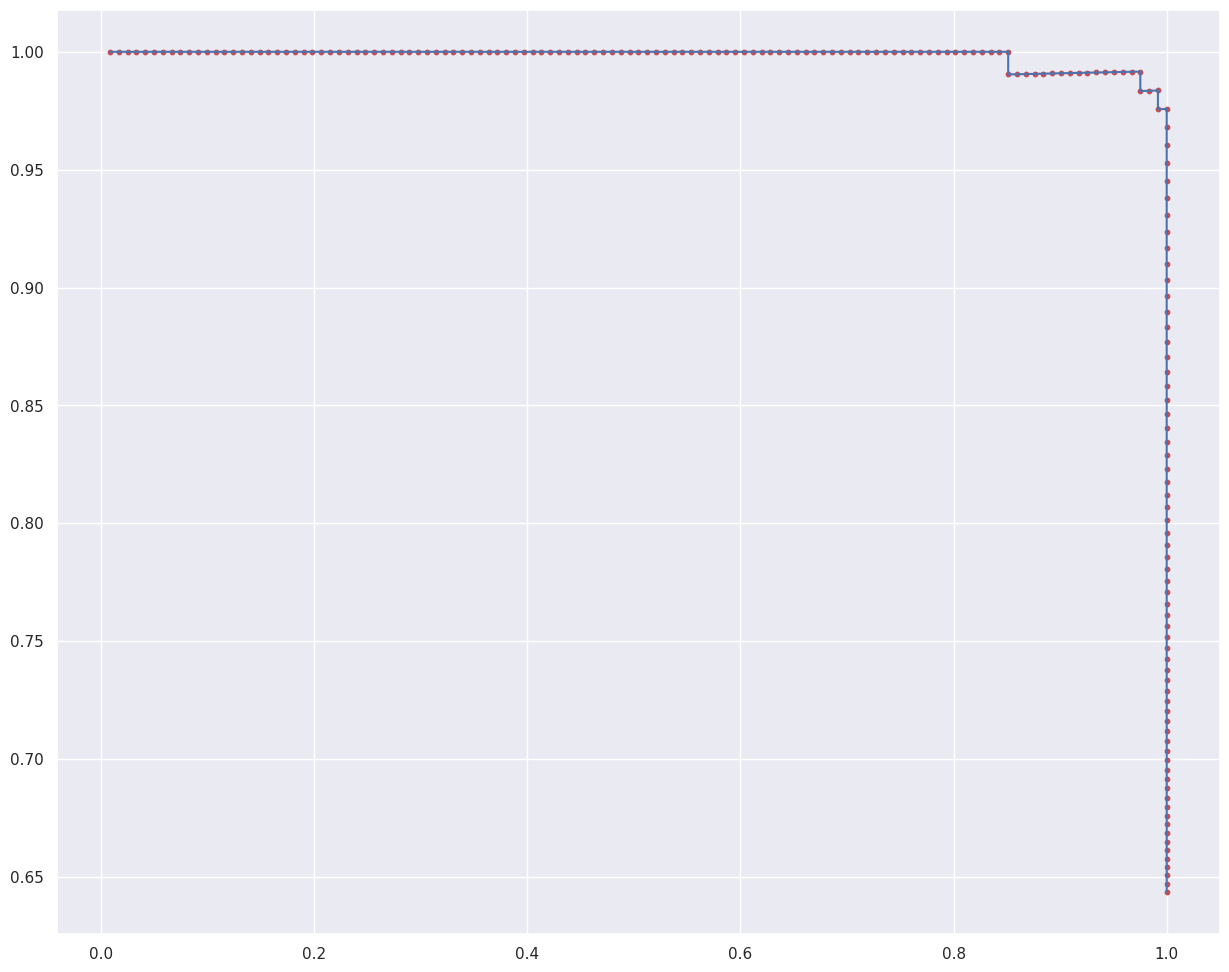

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

plt.figure(figsize=(15, 12))
plt.plot(prec_rec_table.recall, prec_rec_table.precision)
plt.scatter(prec_rec_table.recall, prec_rec_table.precision, c="r", s=10)

На этом графике точками отмечены полученные значения $precision$ и $recall$ при разных порогах классификации. Мы можем заметить, что большинство из них совершенно непригодны для решения данной задачи, поскольку создают явный перекос в одну из сторон, однако здесь же мы видим, что существует возможность улучшения одной из метрик при фиксированной второй для большинства порогов, а также ряд достаточно хороших комбинаций этих параметров (в правом верхнем углу). Именно существование этих хороших комбинаций и обуславливает довольно большую площадь под данной PR-кривой.

Всё это можно было сделать намного проще, применив функцию из `sklearn`:

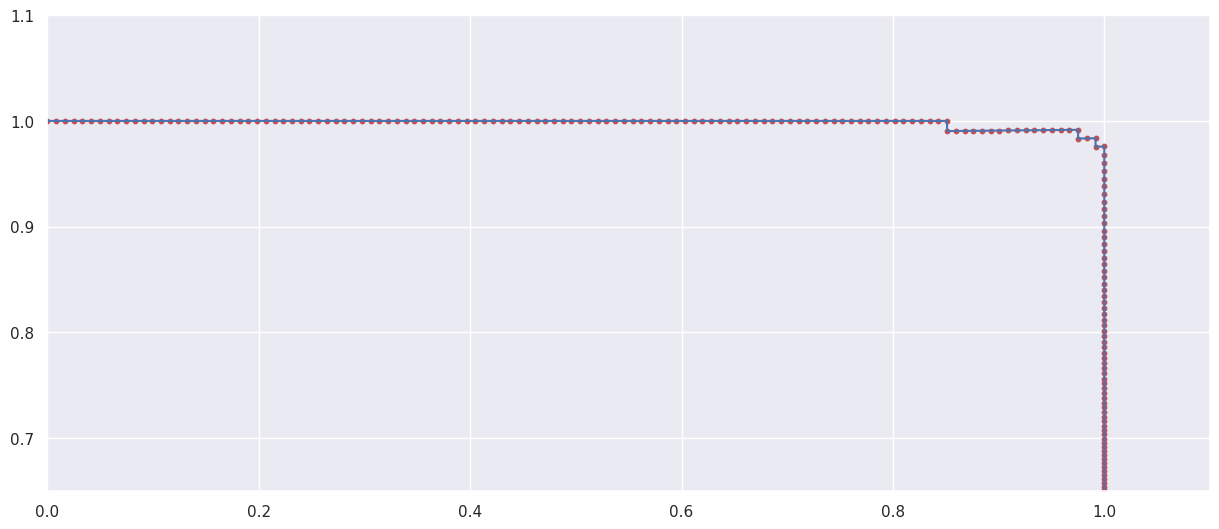

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

precision, recall, thresholds = precision_recall_curve(y_test, probas)

plt.figure(figsize=(15, 12))
plt.plot(recall, precision)
plt.scatter(recall, precision, c="r", s=10)
plt.gca().set_aspect("equal")
plt.xlim([0.0, 1.1])
plt.ylim([0.65, 1.1])
plt.show()

Заметим, что площадь под такой кривой существенно меньше, чем под кривой "разумного" алгоритма. Как мы знаем, это неслучайно.


Попробуем сравнить 2 алгоритма по данной метрике. Обучим, скажем, `KNNClassifier`.

Посчитаем теперь площади аналогичных кривых, однако, теперь уже для тестовых выборок. Сделаем мы это при помощи функции `sklearn.metrics.auc`, позволяющей посчитать площадь ломаной по её узлам, а также воспользуемся функцией `sklearn.metrics.precision_recall_curve`, чтобы не составлять вновь самостоятельно $precision$ и $recall$.

In [ ]:
# Посчитаем pr_auc
from sklearn.metrics import auc, precision_recall_curve

KNN = KNeighborsClassifier().fit(X_train, y_train)

knn_scores = KNN.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, knn_scores)
knn_auc_pr = auc(recall, precision)

lr_scores = LR.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, lr_scores)
lr_auc_pr = auc(recall, precision)

print(f"KNN auc pr = {knn_auc_pr}")
print(f"LR auc pr = {lr_auc_pr}")

KNN auc pr = 0.9866993077310161
LR auc pr = 0.9984125182621637


Нетрудно убедиться, что эта кривая обладает следующими свойствами:
* Левая точка кривой всегда (0,1)
* Если выборка идеально разделима, то кривая пройдет через точку (1,1)
* Чем больше площадь под кривой, тем лучше

Таким образом, площадь под PR-кривой (Precision-Recall) может быть метрикой качества мягкой классификации. Она называется **AUC_PR**.

# ROC-curve
Введем понятия **True Positive Rate** и **False Positive Rate**:

* $False Positive Rate (FPR)$
$$FPR = \frac{FP}{FP + TN}$$

Смысл этой величины - вероятность встретить ошибочную классификацию объекта класса "0".

* $True Positive Rate (TPR)$
$$TPR = \frac{TP}{TP + FN}$$

Смысл этой величины - вероятность встретить верную классификацию объекта класса "1".

Зададим теперь кривую, аналогичную PR-curve, но теперь в координатах $TPR-FPR$.

Такая кривая называется **ROC-curve** *(reciever operating characteristic)*.




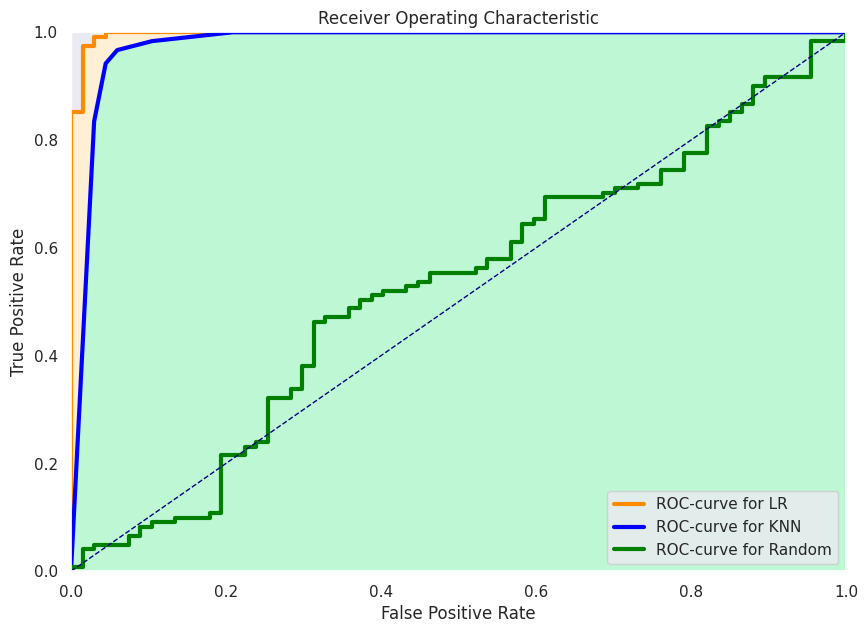

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Получаем вероятности предсказаний для тестовых данных
predictions_lr = LR.predict_proba(X_test)
predictions_knn = KNN.predict_proba(X_test)

plt.figure(figsize=(10, 7))

# Определяем ROC-кривую для модели LR
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, predictions_lr[:, 1])
plt.plot(fpr_lr, tpr_lr, color="darkorange", lw=3, label="ROC-curve for LR")

# Определяем ROC-кривую для модели KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, predictions_knn[:, 1])
plt.plot(fpr_knn, tpr_knn, color="blue", lw=3, label="ROC-curve for KNN")

# Добавляем ROC-кривую случайного алгоритма
fpr_random, tpr_random, _ = roc_curve(
    y_test, np.random.uniform(0, 1, y_test.shape[0])
)
plt.plot(fpr_random, tpr_random, color="green", lw=3, label="ROC-curve for Random")

# Заполняем область под кривыми ROC
plt.fill_between(fpr_lr, tpr_lr, color="papayawhip")
plt.fill_between(fpr_knn, tpr_knn, color="aquamarine", alpha=0.5)

plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")

# Настройка осей и границ графика
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Добавляем метки осей и заголовок
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")

# Добавляем легенду
plt.legend()

# Отображаем график
plt.show()


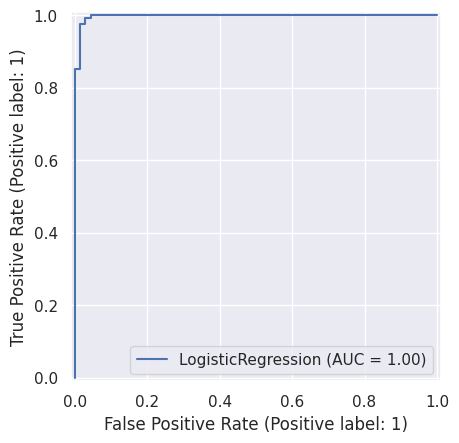

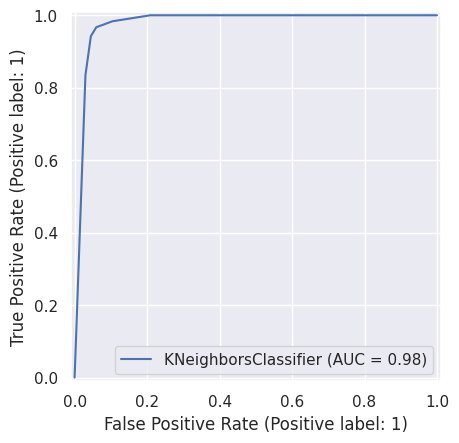

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(LR, X_test, y_test)
RocCurveDisplay.from_estimator(KNN, X_test, y_test)

Посчитать roc_auc можно при помощи функции `sklearn.metrics.roc_auc_score`

In [ ]:
from sklearn.metrics import roc_auc_score

knn_preds = KNN.predict(X_test)
lr_preds = LR.predict(X_test)

auc_lr = roc_auc_score(y_test, lr_preds)
print(f"AUC score for LR model: {auc_lr}")

AUC score for LR model: 0.9801406192179597


In [ ]:
auc_knn = roc_auc_score(y_test, knn_preds)
print(f"AUC score for KNN model: {auc_knn}")

AUC score for KNN model: 0.9536203281115087


Свойства:
* Левая точка (0,0)
* Правая точка (1,1)
* При идеально разделимой выборке кривая пройдет через (0,1)
* Чем больше площадь под кривой, тем лучше
* В случае случайного гадания площадь под кривой равна 0.5

*Метрика качества, соответствующая площади под ROC-curve,* называется **AUC-ROC**.

# Многоклассовая классификация

До этого момента мы рассматривали приоритетно задачу бинарной классификации. Между тем это ограничение довольно сильное. На текущий момент мы не можем решить задачу классификации и оценить качество классификации даже классического датасета Iris (Ирисы Фишера), с которым уже неоднократно встречались.

Придумаем обобщение наших идей для задачи многоклассовой классификации.

Решение задачи многоклассовой классификации строится на многократном решении задач бинарной классификации. Для этого существуют 2 подхода.

Рассмотрим эту задачу на примере уже известного нам датасета Ирисов Фишера.



<Figure size 1000x1000 with 0 Axes>

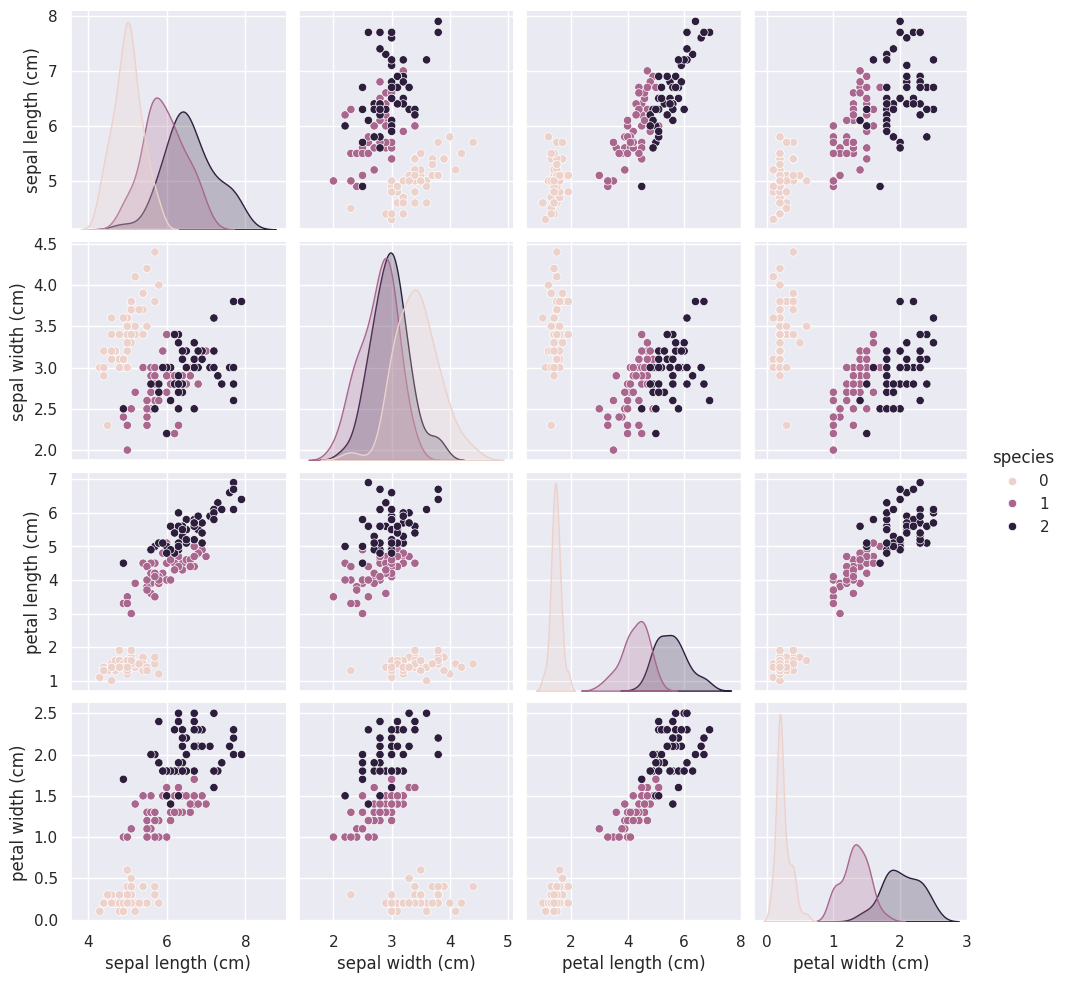

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns

sns.set_theme()
# Загружаем данные
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data["species"] = iris.target

# Создаем экземпляр StandardScaler
sc = StandardScaler()

# Разделяем данные на обучающую и тестовую выборки
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Стандартизируем данные
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Визуализируем данные с помощью pairplot
sns.pairplot(data=data, hue="species")

Как мы видим, эта задача - типичная задача многоклассовой классификации.

## I. One VS All
В этом случае, имея на руках $N$ классов, мы построим $N$ классификаторов $a_1 ... a_N$, каждый из которых будет решать задачу бинарной классификации, предсказывая, принадлежит ли объект $i$-му классу.

В данном случае нас не устроит алгоритм жесткой классификации, потому что в этом случае было бы неясно, что делать, когда несколько классификаторов предсказали принадлежность некоторого объекта своему классу.

Если же алгоритм, с которым мы работаем, выдает вероятность принадлежности $i$-му классу, мы можем выбрать максимальную из предложенных вероятностей.

В случае подхода One vs All мы должны обучить $N$ классификаторов на **всей** выборке (имеющей, очевидно, дисбаланс классов).



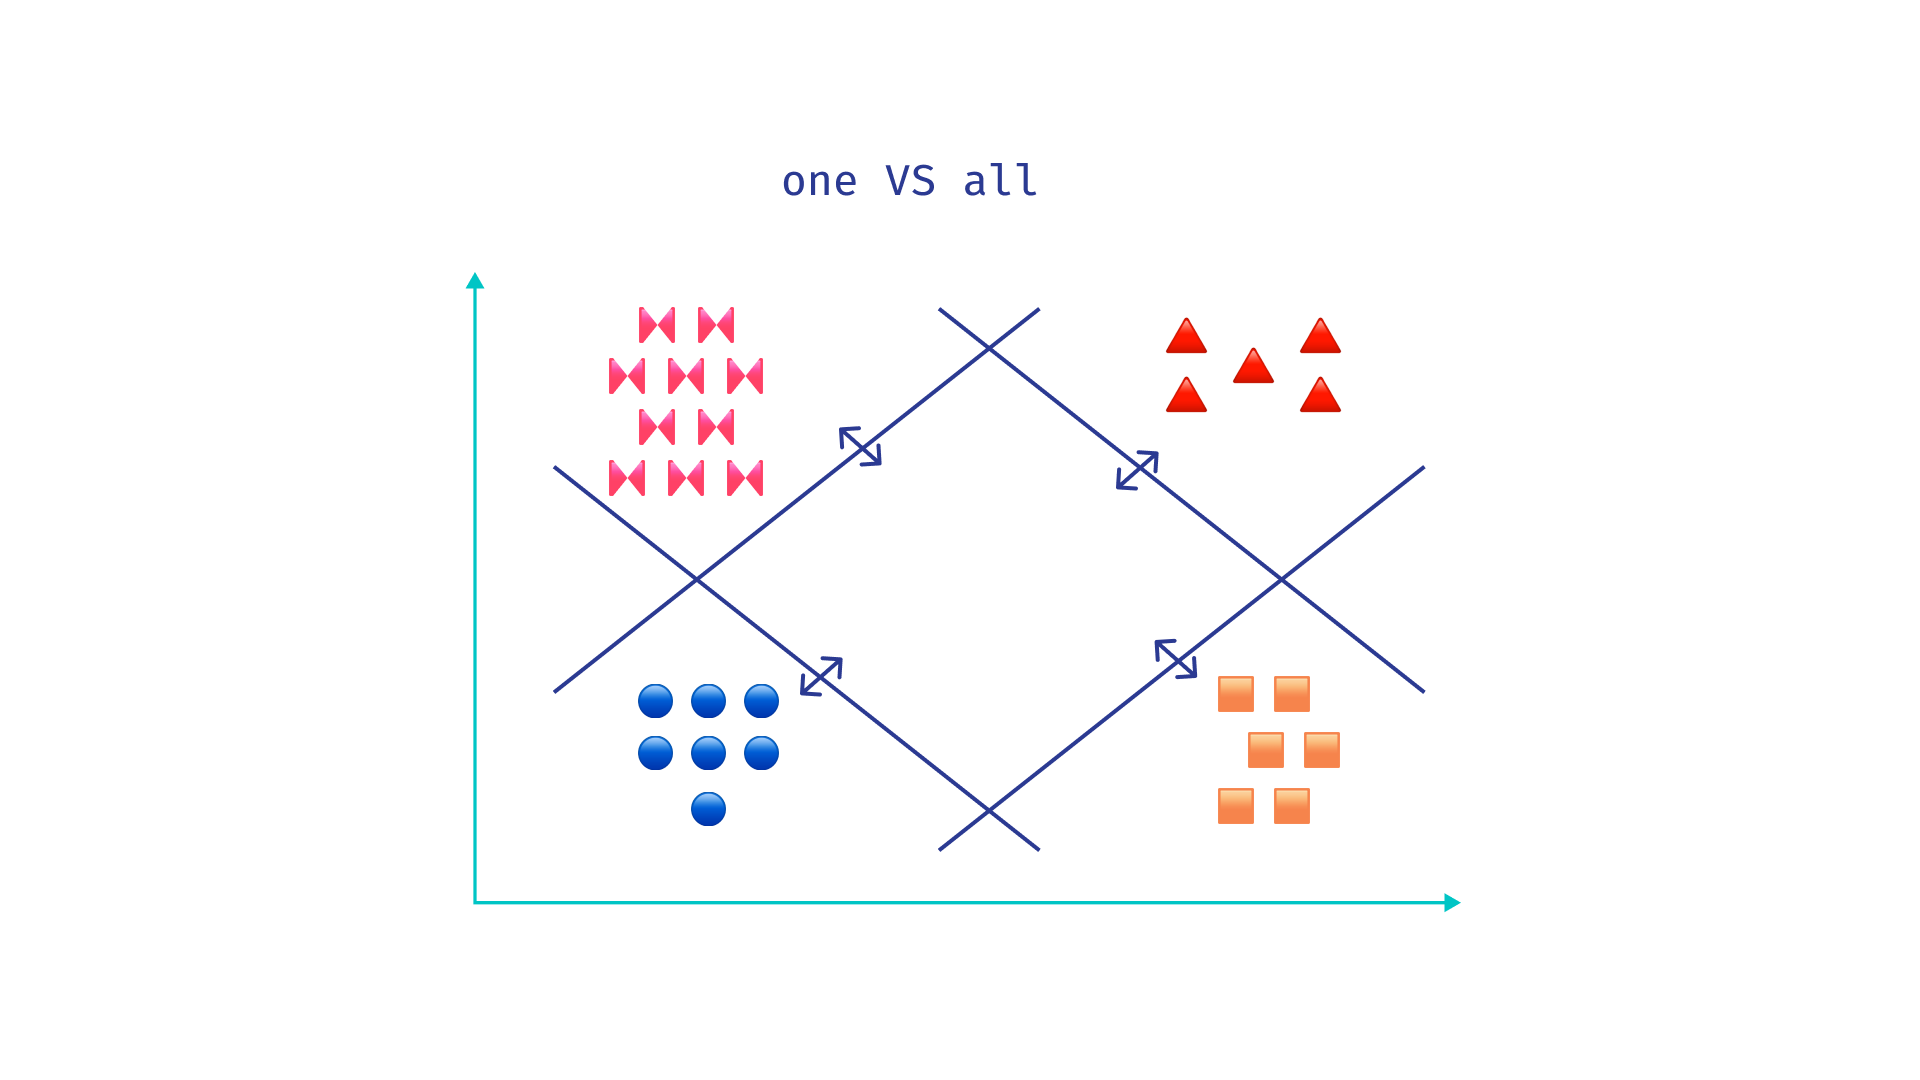

В рамках подхода One VS All мы обучим 3 классификатора, которые будут предсказывать принадлежность объекта каждому из 3 классов.

In [ ]:
y_0_train = (y_train == 0).astype(int)
y_1_train = (y_train == 1).astype(int)
y_2_train = (y_train == 2).astype(int)

y_0_test = (y_test == 0).astype(int)
y_1_test = (y_test == 1).astype(int)
y_2_test = (y_test == 2).astype(int)

LR_0 = LogisticRegression().fit(X_train, y_0_train)
LR_1 = LogisticRegression().fit(X_train, y_1_train)
LR_2 = LogisticRegression().fit(X_train, y_2_train)

Итак, мы обучили 3 классификатора. `LR_0` предсказывает принадлежность объекта классу 0, `LR_1` - классу 1, а `LR_2` - классу 2.

Воспользуемся теперь этими классификаторами, чтобы принять решение о финальной принадлежности произвольного объекта одному из этих трёх классов.

In [ ]:
x = X_test[0]
x

array([-1.04542955,  2.1056559 , -1.47184911, -1.36013259])

In [ ]:
# Ответ первого классификатора
p_0 = LR_0.predict_proba([x])[0][1]
p_0

np.float64(0.9903271510910853)

In [ ]:
# Ответ второго классификатора
p_1 = LR_1.predict_proba([x])[0][1]
p_1

np.float64(0.05280050501020377)

In [ ]:
# Ответ третьего классификатора
p_2 = LR_2.predict_proba([x])[0][1]
p_2

np.float64(1.7853893163134855e-05)

Выберем класс с максимальной вероятностью принадлежности `x`

In [ ]:
prediction = np.argmax([p_0, p_1, p_2])
prediction

np.int64(0)

Узнаем, верна ли классификация

In [ ]:
y_test[0] == prediction

np.True_

Проверим на всей тестовой выборке

In [ ]:
p_0 = LR_0.predict_proba(X_test)[:,1]
p_1 = LR_1.predict_proba(X_test)[:,1]
p_2 = LR_2.predict_proba(X_test)[:,1]

probas = np.stack([p_0, p_1, p_2])
preds = np.argmax(probas, axis=0)
preds

array([0, 2, 0, 1, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 2, 1, 0,
       0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       2])

In [ ]:
accuracy_score(preds, y_test)

0.9111111111111111

## II. All VS All

В этом случае для каждой пары классов мы обучаем свой классификатор, возвращающий вероятность принадлежности объекта одному из них. Таких классификаторов будет $C_N^2 = \frac{N(N-1)}{2}$ ~ $N^2$ штук. В качестве результата работы такого алгоритма мы вернем класс, суммарная вероятность отнести объект к которому максимальна.

В случае подхода All vs All мы должны обучить ~$N^2$ классификаторов на маленькой части выборки.



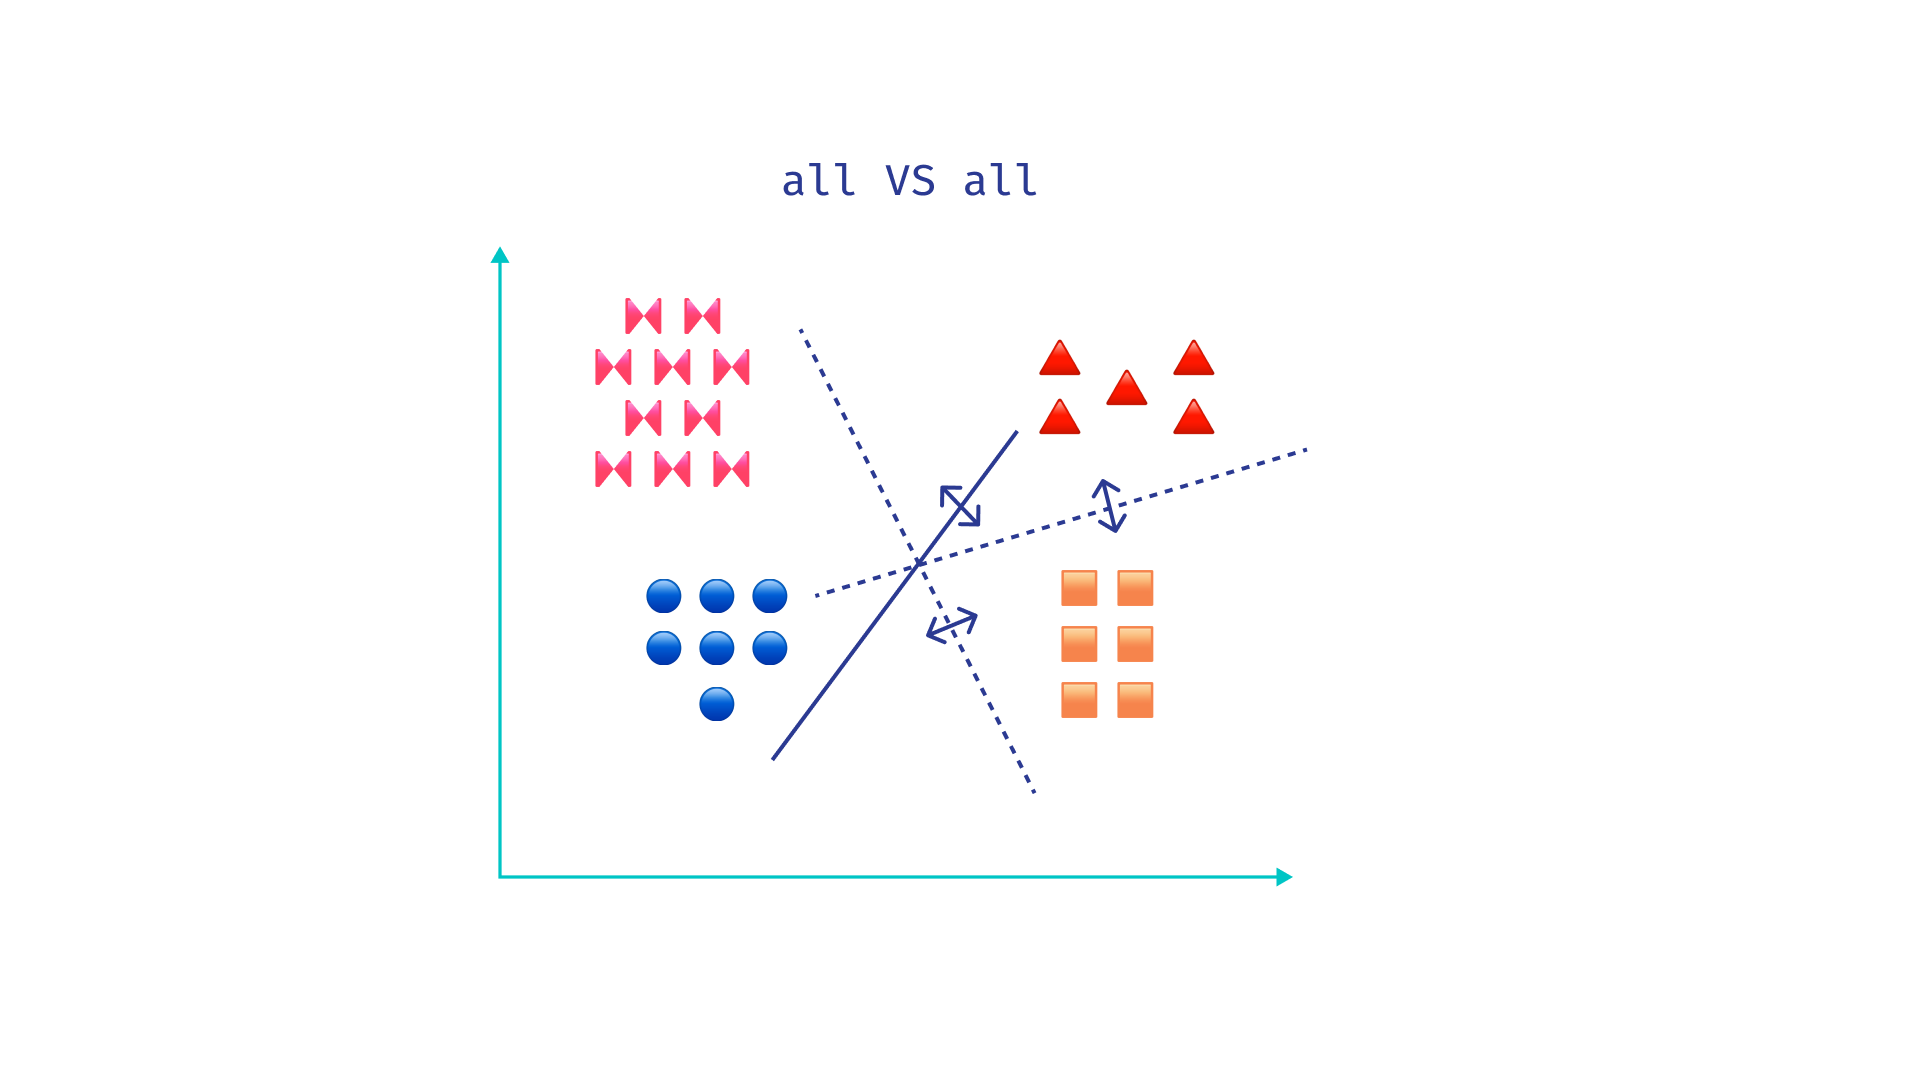

В конкретном примере с Ирисами Фишера нам вновь понадобится 3 классификатора для пар классов $[0-1]$, $[1-2]$, $[0-2]$

In [ ]:
# Пара 0-1
# Здесь мы выкидываем все объекы 2 класса
x_train_01 = X_train[y_train!=2]
y_train_01 = y_train[y_train!=2]

# Пара 0-2
# Здесь мы выкидываем все объекы 1 класса
x_train_02 = X_train[y_train!=1]
y_train_02 = y_train[y_train!=1]

# Пара 1-2
# Здесь мы выкидываем все объекы 0 класса
x_train_12 = X_train[y_train!=0]
y_train_12 = y_train[y_train!=0]

# Обучаем 3 модели
LR_01 = LogisticRegression().fit(x_train_01, y_train_01)
LR_02 = LogisticRegression().fit(x_train_02, y_train_02)
LR_12 = LogisticRegression().fit(x_train_12, y_train_12)

Введем такое обозначение: p_ij - j-я по номеру вероятность принадлежности объекта классу i

In [ ]:
p_01, p_11 = LR_01.predict_proba([x])[0]

In [ ]:
p_01

np.float64(0.9903557031992737)

In [ ]:
p_11

np.float64(0.009644296800726301)

In [ ]:
p_02, p_21 = LR_02.predict_proba([x])[0]

In [ ]:
p_02

np.float64(0.9895366215146781)

In [ ]:
p_21

np.float64(0.010463378485321913)

In [ ]:
p_12, p_22 = LR_12.predict_proba([x])[0]

In [ ]:
p_12

np.float64(0.9999823261677334)

In [ ]:
p_22

np.float64(1.767383226662027e-05)

Тогда суммарная степень принадлежности объекта классу 0:

In [ ]:
p_01 + p_02

np.float64(1.9798923247139517)

Классу 1:

In [ ]:
p_11 + p_12

np.float64(1.0096266229684596)

Классу 2:

In [ ]:
p_21 + p_22

np.float64(0.010481052317588533)


Сделаем то же самое для всех объектов тестовой выборки.

In [ ]:
P0 = LR_01.predict_proba(X_test)
p_01, p_11 = P0[:, 0], P0[:, 1]

P1 = LR_02.predict_proba(X_test)
p_02, p_21 = P1[:, 0], P1[:, 1]

P2 = LR_12.predict_proba(X_test)
p_12, p_22 = P2[:, 0], P2[:, 1]

Prob_0 = p_01 + p_02
Prob_1 = p_11 + p_12
Prob_2 = p_21 + p_22

Preds = np.argmax(np.stack([Prob_0, Prob_1, Prob_2]),axis=0)
Preds

array([0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0,
       0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       2])

In [ ]:
accuracy_score(Preds, y_test)

0.9555555555555556

# Оценка качества многоклассовой классификации

Понятно, что $precision$ и $recall$ теперь недоступны для нас, так как вместо матрицы ошибок размерности 2x2 мы получаем матрицу размерности $N \times N$, где $N$ - число классов.

Однако если мы рассмотрим задачи отделения каждого из $N$ классов от других, как мы уже выяснили, каждая такая задача будет задачей бинарной классификации, и для каждой из них можно посчитать свои $precision$ и $recall$.

Дальше у нас вновь есть 2 пути.



## 1. Микро-усреднение
Для каждой из $N$ задач посчитаем свои $precision$ и $recall$, усредним их и на основе усреднения посчитаем **итоговую метрику** *(roc_auc или pr_auc)*.

Рассмотрим пример:

Пусть для 3 классов имеем следующую таблицу по $precision$ и $recall$.

In [ ]:
import pandas as pd

table = pd.DataFrame({'precision': [0.4, 0.6, 0.8], 'recall': [0.5, 0.7, 0.6]})
table

Микроусреднение предлагает следующую стратегию поведения для вычисления усредненной f1-меры (и любой другой метрики):

In [ ]:
mean_prec, mean_rec = table.precision.mean(), table.recall.mean()
mean_f1 = 2*(mean_prec*mean_rec)/(mean_prec + mean_rec)
mean_f1

0.6

## 2. Макро-усреднение

Для каждой задачи посчитаем $precision$, $recall$ и итоговую метрику. А затем усредним уже значение итоговой метрики.

Несмотря на схожесть двух этих подходов, разница может получиться довольно большой.

In [ ]:
table['f1'] = 2*(table.precision*table.recall)/(table.precision + table.recall)
table

,precision,recall,f1
0,0.4,0.5,0.444444
1,0.6,0.7,0.646154
2,0.8,0.6,0.685714


Итоговое значение $f1$ посчитаем следующим образом:

In [ ]:
table.f1.mean()

0.5921041921041922

## Пример

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Загрузка данных
X, y = load_iris(return_X_y=True)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели логистической регрессии
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [ ]:
y_score = lr_model.predict_proba(X_test_scaled)

In [ ]:
rac_1 = roc_auc_score(y_test, y_score, multi_class='ovo', average='macro')
print(f'Roc Auc для LR, macro-avereging = {rac_1}')

Roc Auc для LR, macro-avereging = 1.0


# Некоторые дополнения об измерении качества регрессии

Мы уже говорили о некоторых способах измерения качества регрессии в прошлых лекциях. В частности, мы обсуждали довольно естественные способы определить качество построенной модели регрессии - **MSE**, **MAE**, **RMSE**. Сегодня мы немного дополним этот список и поговорим об одной из наиболее популярных метрик оценки качества регрессии - $R^2$

Коэффициент детерминации, или, т.н. r-квадрат.

Эта метрика необходима для оценки **доли дисперсии предсказываемой случайной величины, объясняемой моделью регрессии**.

Скажем, что у нас есть некоторая функция, значения которой необходимо научиться предсказывать. Назовём её $z(x)$. Пусть также есть модель регрессии, которая с некоторой точностью предсказывает значение $z(x)$. Модель регрессии назовём $f(x)$. И, само собой, есть некоторая ошибка предсказания. Её мы назовём $ϵ(x)$. Опустим аргументы и запишем следующее равенство:

$$ z = f + ϵ$$

Можно воспринимать последнюю запись, как запись для случайных величин $f$ и $ϵ$. Мы работаем в предположении, что среднее значение ошибки - нулевое. Саму ошибку очень часто принимают выбранной из нормального распределения.

Довольно здравым является предположение о независимости $f$ и  $ϵ$ в терминах случайных величин.

В случае этого предположения, по правилам теории вероятности, можно записать соответствующее равенство на дисперсии:

$$
Dz = Df + Dϵ
$$

Нас же интересует следующая величина:

$$R^2 = \frac{Df}{Dz} = \frac{Dz - Dϵ}{Dz} = 1 - \frac{Dϵ}{Dz}$$

Вспомнив определение дисперсии случайной величины, а также практические способы выборочной оценки [дисперсии](https://colab.research.google.com/drive/1BODfwl4F3c7h0CE-t88zavkZWyNe8n5G#scrollTo=x5FKOPxmoT9S) из математической статистики, несложно выписать выражения:

- Оценку дисперсии ошибки модели можно вычислить по формуле

$Dϵ = \frac{1}{N}∑\limits_{i=1}^N(f(x_i) - y_i)^2$
- Оценку дисперсии случайной величины y можно получить по формуле

$Dz = \frac{1}{N}∑\limits_{i=1}^N(y_i - \bar{y_i})^2$ где $\bar{y_i}$ - среднее значение всех $y_i$

Таким образом, мы приходим к окончательной записи $R^2$:

$$R^2 = 1 - \frac{∑\limits_{i=1}^N(f(x_i) - y_i)^2}{∑\limits_{i=1}^N(y_i - \bar{y_i})^2}$$

Замечание: значение вычитаемой дроби можно интерпретировать и иначе. Обратим внимание, что в числителе этой дроби (при условии деления и числителя и знаменателя на число $N$, которое в данном случае сократилось) стоит $MSE$. А в знаменателе - оценка дисперсии зависимой случайной величины, которую мы предсказываем. То есть по сути, в результате мы получаем *отнормированную* среднеквадратичную ошибку. А затем эту величину вычитаем из 1.

$R^2$ - это величина, которую необходимо **максимизировать**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Генерация двух наборов данных с разной объясняемой дисперсией
np.random.seed(42)
n = 100

y_target1 = np.random.randn(n)# + np.random.randn(n)
y_predicted1 = y_target1 + np.random.randn(n)/5

y_target2 = np.random.randn(n)
y_predicted2 = y_target2 + np.random.randn(n)/2

# Расчет R^2 для обоих наборов данных
r2_1 = r2_score(y_target1, y_predicted1)
r2_2 = r2_score(y_target2, y_predicted2)

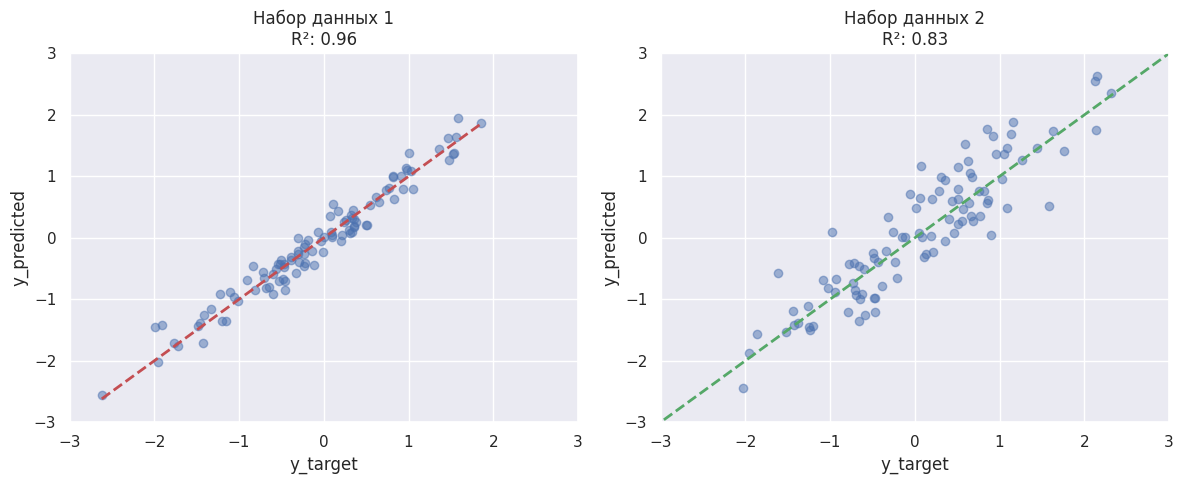

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Первый subplot
ax1.scatter(y_target1, y_predicted1, alpha=0.5)
ax1.plot([y_target1.min(), y_target1.max()], [y_target1.min(), y_target1.max()], 'r--', lw=2)
ax1.set_title(f'Набор данных 1\nR²: {r2_1:.2f}')
ax1.set_xlabel('y_target')
ax1.set_ylabel('y_predicted')

# Второй subplot
ax2.scatter(y_target2, y_predicted2, alpha=0.5)
ax2.plot([y_target2.min(), y_target2.max()], [y_target2.min(), y_target2.max()], 'g--', lw=2)
ax2.set_title(f'Набор данных 2\nR²: {r2_2:.2f}')
ax2.set_xlabel('y_target')
ax2.set_ylabel('y_predicted')


ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

# Настройка осей для второго subplot
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

plt.tight_layout()
plt.show()
